# Multimodal RoBERTa Evaluation

## Imports, Loading Model and Dataset

In [1]:
import pickle
import re
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Softmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup, AutoConfig
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients, TokenReferenceBase, visualization

from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular
from multimodal_transformers.data import load_data


sns.set_theme()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Variables to tune
max_len = 100


# Loading of tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model = torch.load("../models/multimodal_roberta_best_mm.pt")
model.to(device)
model.eval()
model.zero_grad()


# Creating mapping from label name to index
label_2_idx = ['background', 'method', 'result']


# Reading data
train_df = pd.read_json(path_or_buf=r'../scicite/train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'../scicite/test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'../scicite/dev.jsonl', lines=True)


def parse_section_name(raw_section_name):
    if raw_section_name is None or not raw_section_name.strip():
        return ""
    for i, c in enumerate(raw_section_name):
        if c.isalpha():
            break
    section_name = raw_section_name[i:]
    section_name = section_name.lower().strip()

    sn_mappings = {"discussion": {"discussion", "evaluation", "general discussion", "discussion and conclusions", "technical considerations",
                                  "discussion, limitations and conclusion",
                                 },
                   "introduction": {"introduction", "related work", "related works"},
                   "method": {"methods", "experiments", "methodology", "implementation", "experimental setup", "experimental design",
                              "implementation details", "experiment", "numerical experiments", "setup", "experimental settings", "experimental setting",
                              "experiment setup",
                             },
                   "results": {"results", "results and discussion", "conclusions", "experimental results", "conclusion", "results & discussion",
                               "findings",
                              },
                   "background": {"background", "present address:"},
                   "material and methods": {"materials and methods"}
                  }
    for k, sns in sn_mappings.items():
        if section_name in sns:
            return k
    return ""

train_df["sectionName"] = train_df["sectionName"].apply(parse_section_name)
test_df["sectionName"] = test_df["sectionName"].apply(parse_section_name)
val_df["sectionName"] = val_df["sectionName"].apply(parse_section_name)

train_df["label_confidence"] = train_df["label_confidence"].fillna(0.87)
test_df["label_confidence"] = test_df["label_confidence"].fillna(0.87)
val_df["label_confidence"] = val_df["label_confidence"].fillna(0.87)

train_df["label"] = torch.tensor(train_df["label"].apply(lambda row: label_2_idx.index(row)).tolist())
test_df["label"] = torch.tensor(test_df["label"].apply(lambda row: label_2_idx.index(row)).tolist())
val_df["label"] = torch.tensor(val_df["label"].apply(lambda row: label_2_idx.index(row)).tolist())

In [3]:
text_cols = ['string']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label'
categorical_cols = ['source', 'sectionName', 'isKeyCitation']
numerical_cols = ['label_confidence']
label_list = ['background', 'method', 'result'] # what each label class represents

In [4]:
test_ds = load_data(
    test_df,
    text_cols,
    tokenizer,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

batch_size = 8
test_dataloader = torch.utils.data.DataLoader(test_ds,
                                              # sampler=torch.utils.data.RandomSampler(test_ds),
                                              batch_size=batch_size)

num_labels = 3
# config = AutoConfig.from_pretrained('bert-base-uncased')
config = AutoConfig.from_pretrained('roberta-base')
tabular_config = TabularConfig(
    num_labels=num_labels,
    cat_feat_dim=test_ds.cat_feats.shape[1],
    numerical_feat_dim=test_ds.numerical_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats'
)
config.tabular_config = tabular_config

In [ ]:
def evaluate(model, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_pred = []
        y_true = []
        probs = []
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch["labels"]

            loss, logits, _ = model(**batch)
            loss = torch.nn.CrossEntropyLoss()(logits, labels)

            val_loss += loss.item()

            probs.append(F.softmax(logits).detach().cpu().numpy())
            y_pred.append(torch.max(logits, dim=-1)[1].detach().cpu().numpy())
            y_true.append(labels.detach().cpu().numpy())
        # Store train and validation loss history
        probs = np.concatenate(probs)
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        val_loss = val_loss / val_size
        val_f1 = f1_score(y_true, y_pred, average="macro")
    model.train()
    return val_loss, val_f1, y_pred, y_true, probs

test_loss, test_f1, y_pred, y_test, probs = evaluate(model, test_dataloader, len(test_dataloader))

test_df["pred"] = [label_2_idx[y] for y in y_pred]
test_df["label"] = [label_2_idx[y] for y in y_test]
test_df

## Analysis

In [147]:
print(roc_auc_score(test_df["label"], probs, multi_class='ovo'))
print(classification_report(test_df["label"], test_df["pred"]))

0.9668263018951447
              precision    recall  f1-score   support

  background       0.89      0.87      0.88       997
      method       0.91      0.82      0.86       605
      result       0.68      0.93      0.79       259

    accuracy                           0.86      1861
   macro avg       0.83      0.87      0.84      1861
weighted avg       0.87      0.86      0.86      1861



In [16]:
print(f1_score(test_df["label"], test_df["pred"], average="macro"))

0.8426411513363457


### Confusion Matrix

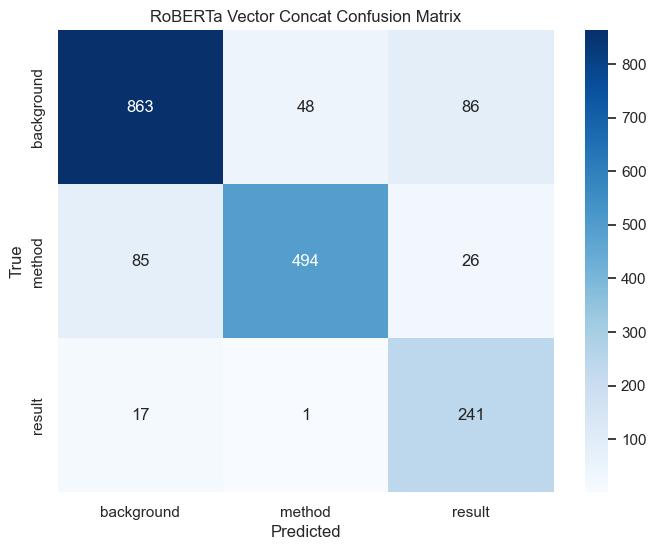

In [7]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RoBERTa Vector Concat Confusion Matrix')
plt.show()

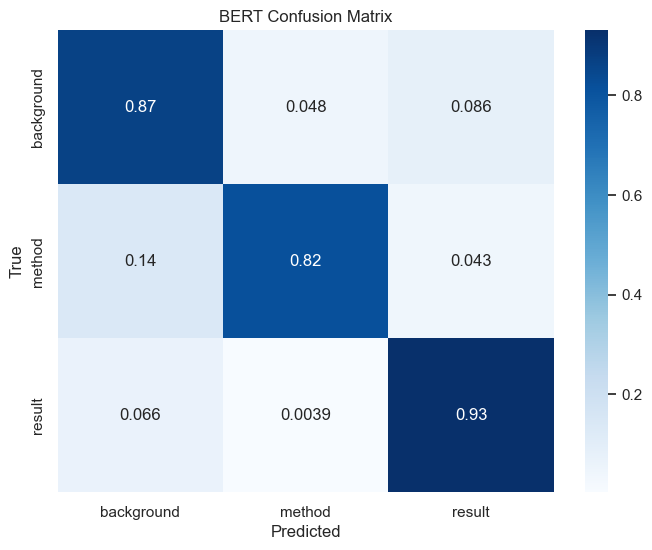

In [149]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()

Actually most misclassification comes from method being misclassified as background.

### Try to find something

In [ ]:
test_df[(test_df["sectionName"] == "method") & (test_df["label"] == test_df["pred"])]

In [ ]:
x = test_df.loc[(test_df["label"] == "method") & (test_df["label"] != test_df["pred"])]
x[["sectionName", "label", "pred"]]

In [15]:
x.sectionName.value_counts()

method          50
                31
results         13
discussion      12
introduction     5
Name: sectionName, dtype: int64

In [14]:
x = test_df.loc[(test_df["label"] == "method") & (test_df["label"] != test_df["pred"])]
x[["sectionName", "label", "pred"]]

,sectionName,label,pred
9,results,method,background
14,,method,result
16,,method,background
32,,method,background
41,,method,background
...,...,...,...
1701,method,method,background
1707,method,method,background
1713,method,method,background
1798,method,method,background


In [15]:
x.sectionName.value_counts()

method          50
                30
results         13
discussion      12
introduction     5
Name: sectionName, dtype: int64

In [16]:
x[x["pred"] == "background"].sectionName.value_counts()

method          35
                24
results         12
discussion       8
introduction     5
Name: sectionName, dtype: int64

In [17]:
x[x["pred"] == "result"].sectionName.value_counts()

method        15
               6
discussion     4
results        1
Name: sectionName, dtype: int64

In [18]:
y = test_df.loc[(test_df["label"] == "method") & (test_df["pred"] == "method")]
y.sectionName.value_counts()

method                  364
                         62
results                  53
discussion               15
material and methods      1
Name: sectionName, dtype: int64

In [19]:
y = test_df.loc[(test_df["label"] == "background") & (test_df["pred"] == "background")]
y.sectionName.value_counts()

discussion      448
results         204
                129
introduction     68
method            9
background        4
Name: sectionName, dtype: int64

In [20]:
y = test_df.loc[(test_df["label"] == "result") & (test_df["pred"] == "result")]
y.sectionName.value_counts()

discussion      210
results          16
                 11
introduction      2
Name: sectionName, dtype: int64

Substantial number of misclassified methods have section name "method", this should highly suggest that it is a method since background and result have very very few method section names.

### Examples of each label

In [ ]:
for row in train_df[train_df["label"] == "background"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "method"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "result"]["string"][:5]:
    print(row)
    print()

## Get Attributions

In [40]:
def predict(inputs, mask):
    output = model(inputs, attention_mask=mask)  # model(input_ids, attention_mask=attention_mask)
    return F.softmax(output.logits, dim=-1)


def predict2(inputs, mask):
    output = model(inputs, attention_mask=mask)
    return torch.sigmoid(output.logits).max(1).indices


def interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target="pred", device="cpu", debug=False):
    model.zero_grad()
    text = tokenizer.tokenize(sentence)

    # input_indices = torch.tensor([tokenizer.encode(sentence, padding="max_length", max_length=max_len)]).to(device)
    #input_indices = input_indices.unsqueeze(0)
    text_enc = tokenizer.encode_plus(sentence, padding="max_length", max_length=max_len)
    input_indices = torch.tensor([text_enc["input_ids"]]).to(device)
    mask = torch.tensor([text_enc["attention_mask"]]).to(device)

    # predict
    pred_probs = predict(input_indices, mask)
    pred_ind = predict2(input_indices, mask).item()
    pred = label_2_idx[pred_ind]

    # generate reference indices for each sample
    # reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    reference_indices = input_indices.clone()
    reference_indices[(input_indices != 0) & (input_indices != 2)] = 1
    reference_indices.to(device)
    ref_mask = torch.zeros(reference_indices.size()).to(device)
    # compute attributions and approximation delta using layer integrated gradients
    label_idx = label_2_idx.index(label)
    if target == "pred":
        target = pred_ind
    else:
        target = label_idx
    attributions_ig, delta = lig.attribute((input_indices, mask), (reference_indices, ref_mask), target=target, n_steps=50, return_convergence_delta=True)
    if debug:
        print(text)
        print(f"Ref: {reference_indices}")
        print(f"Input indices: {input_indices}")
        print(attributions_ig.sum(dim=2).squeeze(0))
        print(f"last non-zero index: {attributions_ig.sum(dim=2).squeeze(0).nonzero().max()}, {(input_indices[0] == 2).nonzero(as_tuple=True)[0].item()}")
        print(pred_ind, pred)
        print(pred_probs)
        print('pred: ', pred_ind, '(', '%.2f'%pred_probs.max(1).values, ')', ', delta: ', abs(delta))

    text = [tokenizer.decode(idx) for idx in input_indices[0]]

    add_attributions_to_visualizer(attributions_ig, text, pred_probs, pred, label, delta, vis_data_records_ig)


def add_attributions_to_visualizer(attributions, text, pred_probs, pred, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # Remove padding
    try:
        first_pad_idx = text.index(tokenizer.pad_token)
        text = text[:first_pad_idx]
        attributions = attributions[:first_pad_idx]
    except ValueError:
        pass
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_probs.max(1).values.item(),
                            pred,
                            label,
                            0,
                            attributions.sum(),
                            text,
                            delta))


def interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=0, target="pred", device="cpu", debug=False):
    vis_data_records_ig = []

    lig = LayerIntegratedGradients(predict, model.roberta.embeddings)
    
    token_reference = TokenReferenceBase(reference_token_idx=pad_idx)

    for idx, row in df.iterrows():
        torch.cuda.empty_cache()
        sentence = row["string"]
        label = row["label"]
        interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target=target, device=device, debug=debug)
    return vis_data_records_ig

In [10]:
all_attributions = list()
torch.cuda.empty_cache()
vis_data_records_ig = interpret_batch(test_df, model, predict, max_len, label_2_idx, pad_idx=1, target="pred", device=device, debug=False)
all_attributions = [{"input_ids": record.raw_input_ids, 
                     "attributions": record.word_attributions, 
                     "label": record.true_class, 
                     "pred": record.pred_class, 
                    } for record in vis_data_records_ig]

background
method
result


In [12]:
# Save attributions to prevent the need for running calculations again
# with open("attributions.pkl", "wb") as f:
#     pickle.dump(all_attributions, f)
with open("attributions.pkl", "rb") as f:
    all_attributions = pickle.load(f)

## Analyze Attributions

In [26]:
def get_ngram_attributions(records, pred, n=1):
    ngram_attrs = defaultdict(lambda: [[]])
    for record in records:
        if record["pred"] == pred:
            tokens = record["input_ids"]
            attributions = record["attributions"]
            for i in range(len(tokens) + n - 1):
                ngram = tuple(tokens[i:i+n])
                ngram_attr = attributions[i:i+n].sum() / n
                ngram_attrs[ngram][0].append(ngram_attr)
    return ngram_attrs


def get_ngram_attribution_df(ngram_attributions):
    ngram_attributions_df = pd.DataFrame.from_dict(ngram_attributions, orient="index").reset_index().rename(columns={"index": "ngram", 0: "attribution"})

    ngram_attributions_df.attribution = ngram_attributions_df.attribution.apply(lambda x: np.array(x))
    ngram_attributions_df["mean"] = ngram_attributions_df.attribution.apply(lambda x: x.mean())
    ngram_attributions_df["median"] = ngram_attributions_df.attribution.apply(lambda x: np.median(x))
    ngram_attributions_df["std"] = ngram_attributions_df.attribution.apply(lambda x: x.std())
    ngram_attributions_df["count"] = ngram_attributions_df.attribution.apply(lambda x: len(x))
    
    ngram_attributions_df.sort_values("mean", ascending=False, inplace=True)
    
    return ngram_attributions_df

### Visualize attributions of sentences

In [54]:
label = "background"  # background, method, result
target = "pred"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to pred:


Incorrectly classified texts with reference to pred:


In [9]:
label = "background"  # background, method, result
target = "label"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to label:


Incorrectly classified texts with reference to label:


In [28]:
label = "background"  # background, method, result
pred = "method"
target = "pred"

print(f"Classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == pred)].iloc[:10]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Classified texts with reference to pred:


### Get distribution of attribution scores

Background mean: 0.01, median: 0.01, max: 0.92, min: -0.97
Method mean: 0.03, median: 0.01, max: 0.99, min: -0.97
Result mean: 0.04, median: 0.01, max: 0.98, min: -0.76


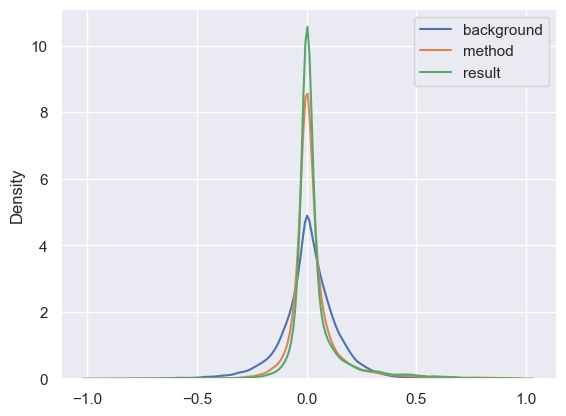

In [8]:
background_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "background"]
method_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "method"]
result_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "result"]
sns.kdeplot(background_attributions, label="background")
sns.kdeplot(method_attributions, label="method")
sns.kdeplot(result_attributions, label="result")
plt.legend()
print(f"Background mean: {np.mean(background_attributions):.2f}, median: {np.median(background_attributions):.2f}, max: {np.max(background_attributions):.2f}, min: {np.min(background_attributions):.2f}")
print(f"Method mean: {np.mean(method_attributions):.2f}, median: {np.median(method_attributions):.2f}, max: {np.max(method_attributions):.2f}, min: {np.min(method_attributions):.2f}")
print(f"Result mean: {np.mean(result_attributions):.2f}, median: {np.median(result_attributions):.2f}, max: {np.max(result_attributions):.2f}, min: {np.min(result_attributions):.2f}")

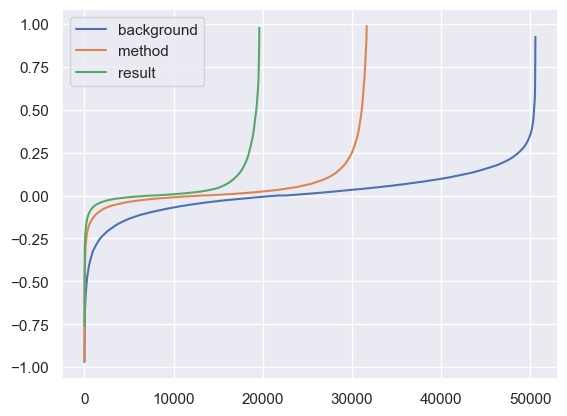

In [12]:
background_attributions.sort()
method_attributions.sort()
result_attributions.sort()
sns.lineplot(background_attributions, label="background")
sns.lineplot(method_attributions, label="method")
sns.lineplot(result_attributions, label="result")
plt.legend()

Attribution distribution for method and result labels are narrower, suggesting that there is a smaller set of words that determine the labels for these 2. More certainty of the 2 labels when certain words appear.

### Looking into methods misclassified as background

In [129]:
df = test_df[(test_df["label"] == "method") & (test_df["pred"] == "background")]
df

,string,label,pred
5,Mouse embryonic fibroblasts (MEFs) were also i...,method,background
32,…and valid across a number of studies (Evins a...,method,background
41,"Given a source of prior knowledge, Gelly and S...",method,background
51,…d (subject to g > 0) gives the analytic solut...,method,background
80,Intercept terms were excluded from these triva...,method,background
...,...,...,...
1701,"4-11, column a an arrangement is depicted, whe...",method,background
1707,Some subjects (13 of 18) had previously partic...,method,background
1798,The two cases of egovernment sustainability at...,method,background
1817,The starting point of the TMD simulations was ...,method,background


In [ ]:
for _, row in df.iterrows():
    print(row["string"])
    print()

In [ ]:
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target="pred", device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

In [ ]:
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target="label", device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

In [73]:
t = test_df[(test_df["label"] == "method") & (test_df["pred"] == "method")]
t

,string,label,pred
3,Organotypic hippocampal slice cultures\nInterf...,method,method
9,"After secondary review, 93 studies were includ...",method,method
14,"In order to compare our method with [11], the ...",method,method
16,"Then, for each DCT band, the parity bit stream...",method,method
19,"Briefly, iMyoD-transduced cells were seeded on...",method,method
...,...,...,...
1835,"Therefore, the approach of this work is experi...",method,method
1838,[Ca21]i was ascertained by using the fluoresce...,method,method
1846,‚Ä¶used sections taken from female Wistar and ...,method,method
1858,The data obtained from this crosssectional sur...,method,method


In [124]:
text = 'previous'
text_enc = tokenizer(text, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

inputs = {'input_ids': text_enc["input_ids"].to(device),
          'attention_mask': text_enc["attention_mask"].to(device),
         }
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
# ['background', 'method', 'result']
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 4.6342, -0.4479, -3.6076]], device='cuda:0'), hidden_states=None, attentions=None)

In [125]:
text = ""
vis_data_records_ig = []

lig = LayerIntegratedGradients(predict, model.roberta.embeddings)

token_reference = TokenReferenceBase(reference_token_idx=1)

torch.cuda.empty_cache()
interpret_sentence(model, text, vis_data_records_ig, max_len, token_reference, lig, "background", label_2_idx, target="pred", device=device)
_ = visualization.visualize_text(vis_data_records_ig)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
background,background (0.96),0,nan,#s #/s


In [49]:
# Keys: input_ids, attributions, label, pred
records = [record for record in all_attributions if record["pred"] == "background" and record["label"] == "method"]
tok_counts = Counter([tok for record in records for tok in record["input_ids"]])

b = m = 0
for record in records:
    for tok in record["input_ids"]:
        if tok in top_n_tokens["method"]:
            m += 1
        if tok in top_n_tokens["background"]:
            b += 1
tot_toks = sum(tok_counts.values())
print(b / tot_toks, m / tot_toks, b, m, tot_toks)

0.0039361469494861145 0.021867483052700636 18 100 4573


In [50]:
# Keys: input_ids, attributions, label, pred
records = [record for record in all_attributions if record["pred"] == "method" and record["label"] == "method"]
tok_counts = Counter([tok for record in records for tok in record["input_ids"]])

b = m = 0
for record in records:
    for tok in record["input_ids"]:
        if tok in top_n_tokens["method"]:
            m += 1
        if tok in top_n_tokens["background"]:
            b += 1
tot_toks = sum(tok_counts.values())
print(b / tot_toks, m / tot_toks, b, m, tot_toks)

0.0029493154675211187 0.04675211185551995 81 1284 27464


In [51]:
# Keys: input_ids, attributions, label, pred
records = [record for record in all_attributions if record["pred"] == "background" and record["label"] == "background"]
tok_counts = Counter([tok for record in records for tok in record["input_ids"]])

b = m = 0
for record in records:
    for tok in record["input_ids"]:
        if tok in top_n_tokens["method"]:
            m += 1
        if tok in top_n_tokens["background"]:
            b += 1
tot_toks = sum(tok_counts.values())
print(b / tot_toks, m / tot_toks, b, m, tot_toks)

0.006768038827170114 0.012534229801634125 304 563 44917


### Get top n tokens for each label

In [27]:
n = 30

top_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[df["count"] > 5].sort_values("mean", ascending=False)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    top_n_tokens[pred] = set(toks)

bot_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[df["count"] > 5].sort_values("mean", ascending=True)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    bot_n_tokens[pred] = set(toks)

#### Find the proportion of top n tokens in sentences

In [21]:
def get_proportions_top_n(n_tokens, correct_pred=True, reference="pred"):
    correct = "correctly" if correct_pred else "wrongly"
    ref = f" from {reference} class" if not correct_pred else ""
    print(f"Proportion of {correct} labelled records with n tokens{ref} in them.")
    for pred in ("background", "method", "result"):
        tot_correct_pred = 0
        tot_correct_w_top_n_pred = 0
        for record in all_attributions:
            if record["pred"] == pred and (record["pred"] == record["label"] if correct_pred else record["pred"] != record["label"]):
                tot_correct_pred += 1
                for tok in record["input_ids"]:
                    if tok in n_tokens[pred if reference == "pred" else record["label"]]:
                        tot_correct_w_top_n_pred += 1
                        break
        print(pred, tot_correct_w_top_n_pred, tot_correct_pred, tot_correct_w_top_n_pred / tot_correct_pred)

In [22]:
get_proportions_top_n(top_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 245 848 0.28891509433962265
method 474 497 0.9537223340040242
result 232 238 0.9747899159663865

Proportion of wrongly labelled records with n tokens from pred class in them.
background 21 106 0.19811320754716982
method 69 81 0.8518518518518519
result 85 91 0.9340659340659341

Proportion of wrongly labelled records with n tokens from label class in them.
background 81 106 0.7641509433962265
method 13 81 0.16049382716049382
result 42 91 0.46153846153846156


In [23]:
get_proportions_top_n(bot_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 848 848 1.0
method 164 497 0.3299798792756539
result 116 238 0.48739495798319327

Proportion of wrongly labelled records with n tokens from pred class in them.
background 106 106 1.0
method 22 81 0.2716049382716049
result 50 91 0.5494505494505495

Proportion of wrongly labelled records with n tokens from label class in them.
background 40 106 0.37735849056603776
method 81 81 1.0
result 72 91 0.7912087912087912


### Get high attribution N-grams

In [ ]:
pred = "background"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "method"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "result"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

#### Why are the ngrams for background so shit?
Check if there are alot more [0] kind of tokens in background texts.

In [106]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("\[[^\]]*\]", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.5217903415783275 0.0 16 0
method 0.6471774193548387 0.0 7 0
result 0.6 0.0 10 0


In [107]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("et[^(et)]*al", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.8845700824499411 0.0 15 0
method 0.5443548387096774 0.0 7 0
result 1.0085106382978724 0.0 15 0
